In [1]:
import os
import random
from glob import glob

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import torchvision
from torchvision import transforms
from PIL import Image

from tqdm import tqdm

In [2]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
dataset_path = "/kaggle/input/skin-cancer-mnist-ham10000"
metadata = pd.read_csv(os.path.join(dataset_path, "HAM10000_metadata.csv"))
num_examples = len(metadata)
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
metadata.isna().sum()/num_examples*100

lesion_id       0.000000
image_id        0.000000
dx              0.000000
dx_type         0.000000
age             0.569146
sex             0.000000
localization    0.000000
dtype: float64

In [5]:
metadata['age'].fillna(metadata['age'].median(), inplace = True) # Пропуски возрастов можно оставить
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma', 
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

metadata['label'] = metadata['dx'].map(lesion_type_dict)

In [6]:
codes = list(set(metadata['dx'].values))
codes.sort()
codes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [7]:
image_path = {}
for part in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    folder_path = os.path.join(dataset_path, part)
    part_images = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(folder_path, '*.jpg'))}
    image_path.update(part_images)

print(f"Found {len(image_path)} images")

Found 10015 images


In [8]:
metadata['path'] = metadata['image_id'].map(image_path)

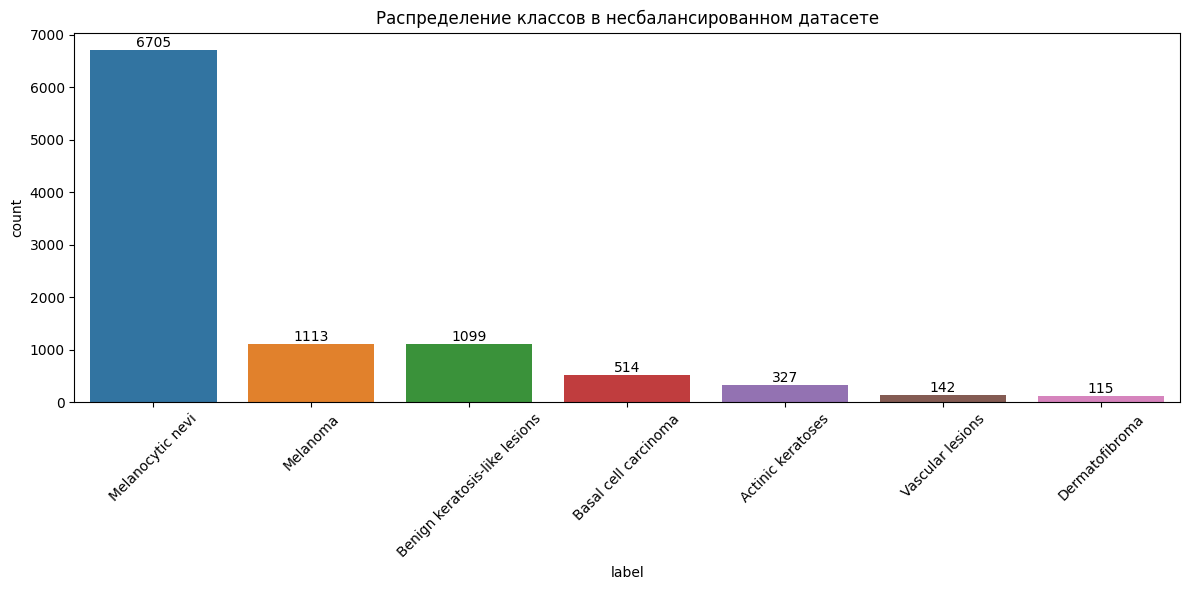

In [9]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x='label', data=metadata, order=metadata['label'].value_counts().index)
plt.title('Распределение классов в несбалансированном датасете')
plt.xticks(rotation=45)

# Добавляем подписи с количеством над каждым столбцом
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
ratio = round(np.max(metadata['dx'].value_counts())/metadata['dx'].value_counts())
ratio = pd.to_numeric(ratio, downcast = 'integer')
ratio = ratio.sort_index()
ratio

dx
akiec    21
bcc      13
bkl       6
df       58
mel       6
nv        1
vasc     47
Name: count, dtype: int8

In [11]:
metadata['dx'] = metadata['dx'].map(lambda x: codes.index(x))
metadata_balanced = pd.concat([metadata[metadata['dx'] == 0]]*ratio[0])
for i in range(1, 7):
    metadata_balanced = pd.concat([metadata_balanced]+[metadata[metadata['dx'] == i]]*ratio[i])
metadata_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46870 entries, 9687 to 2461
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     46870 non-null  object 
 1   image_id      46870 non-null  object 
 2   dx            46870 non-null  int64  
 3   dx_type       46870 non-null  object 
 4   age           46870 non-null  float64
 5   sex           46870 non-null  object 
 6   localization  46870 non-null  object 
 7   label         46870 non-null  object 
 8   path          46870 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 3.6+ MB


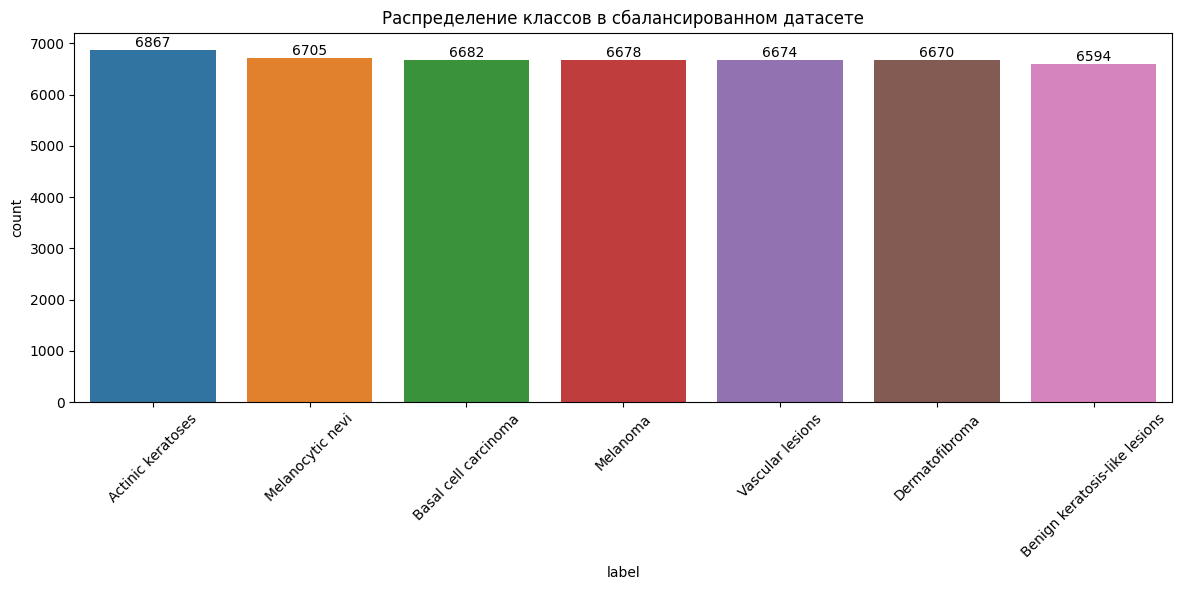

In [12]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x='label', data=metadata_balanced, order=metadata_balanced['label'].value_counts().index)
plt.title('Распределение классов в сбалансированном датасете')
plt.xticks(rotation=45)

# Добавляем подписи с количеством над каждым столбцом
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

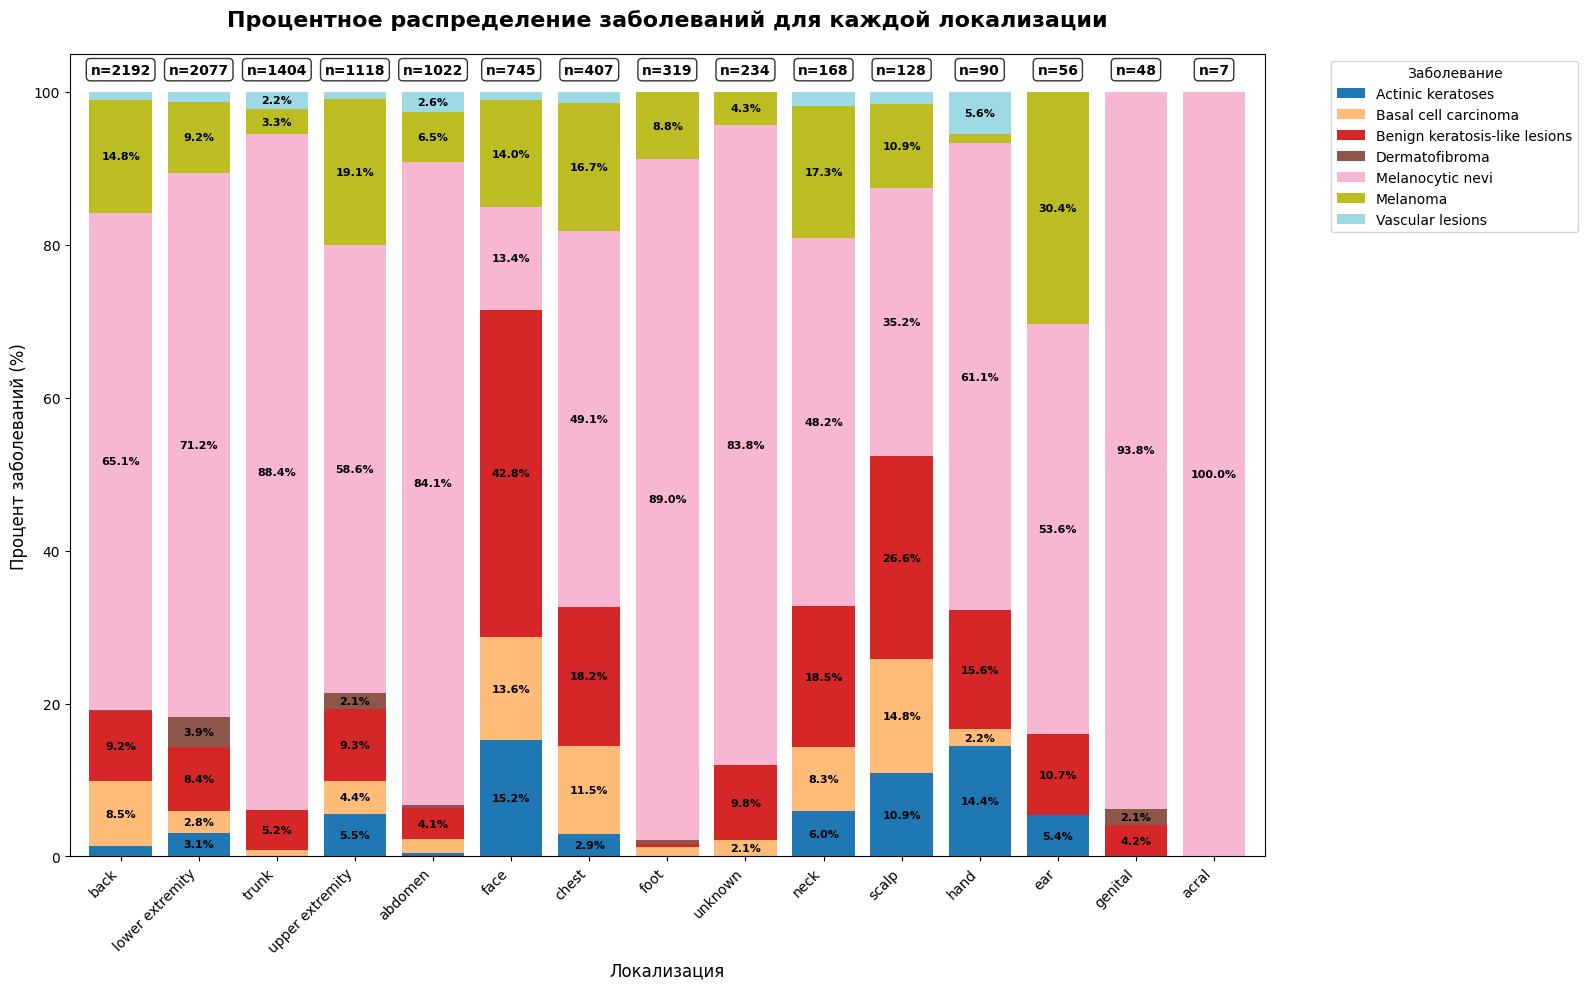

In [13]:
plt.figure(figsize=(12, 6))

cross_tab = pd.crosstab(metadata['localization'], metadata['label'])
localization_order = cross_tab.sum(axis=1).sort_values(ascending=False).index
cross_tab_perc = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Сортируем по общему количеству случаев
cross_tab_perc = cross_tab_perc.loc[localization_order]

ax = cross_tab_perc.plot(kind='bar', 
                         stacked=True, 
                         figsize=(16, 10), 
                         colormap='tab20',
                         width=0.8)

plt.title('Процентное распределение заболеваний для каждой локализации', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Локализация', fontsize=12)
plt.ylabel('Процент заболеваний (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Заболевание', bbox_to_anchor=(1.05, 1), loc='upper left')

for i, (loc, row) in enumerate(cross_tab_perc.iterrows()):
    cumulative = 0
    for disease, percentage in row.items():
        if percentage > 2: 
            ax.text(i, cumulative + percentage/2, f'{percentage:.1f}%', 
                   ha='center', va='center', fontsize=8, fontweight='bold',
                   color='black')
        cumulative += percentage

# Добавляем общее количество справа
for i, loc in enumerate(cross_tab_perc.index):
    total = cross_tab.loc[loc].sum()
    ax.text(i, 102, f'n={total}', ha='center', va='bottom', fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

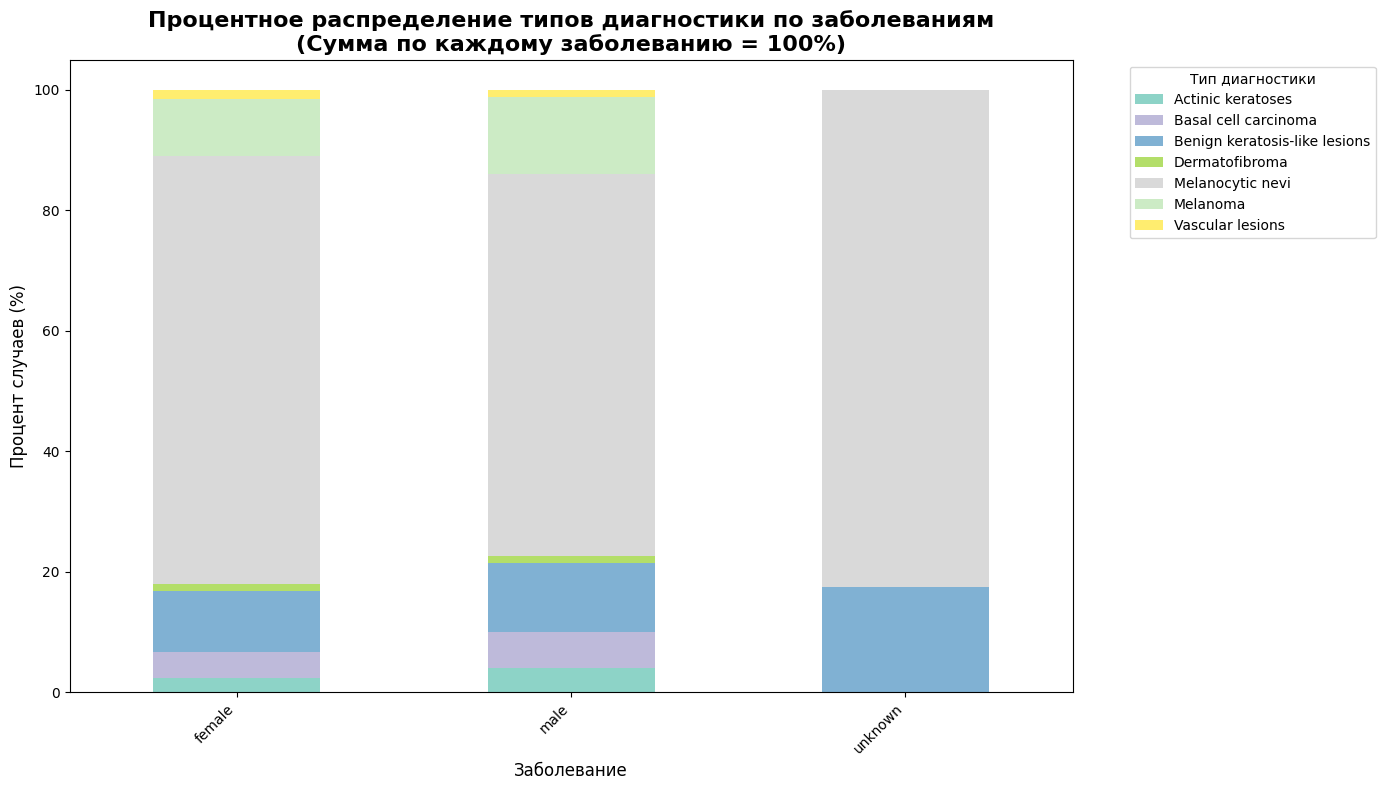

In [14]:
plt.figure(figsize=(14, 8))

cross_tab = pd.crosstab(metadata['sex'], metadata['label'])
cross_tab_perc = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

ax = cross_tab_perc.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Set3')

plt.title('Процентное распределение типов диагностики по заболеваниям\n(Сумма по каждому заболеванию = 100%)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Заболевание', fontsize=12)
plt.ylabel('Процент случаев (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Тип диагностики', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

<Figure size 1600x1000 with 0 Axes>

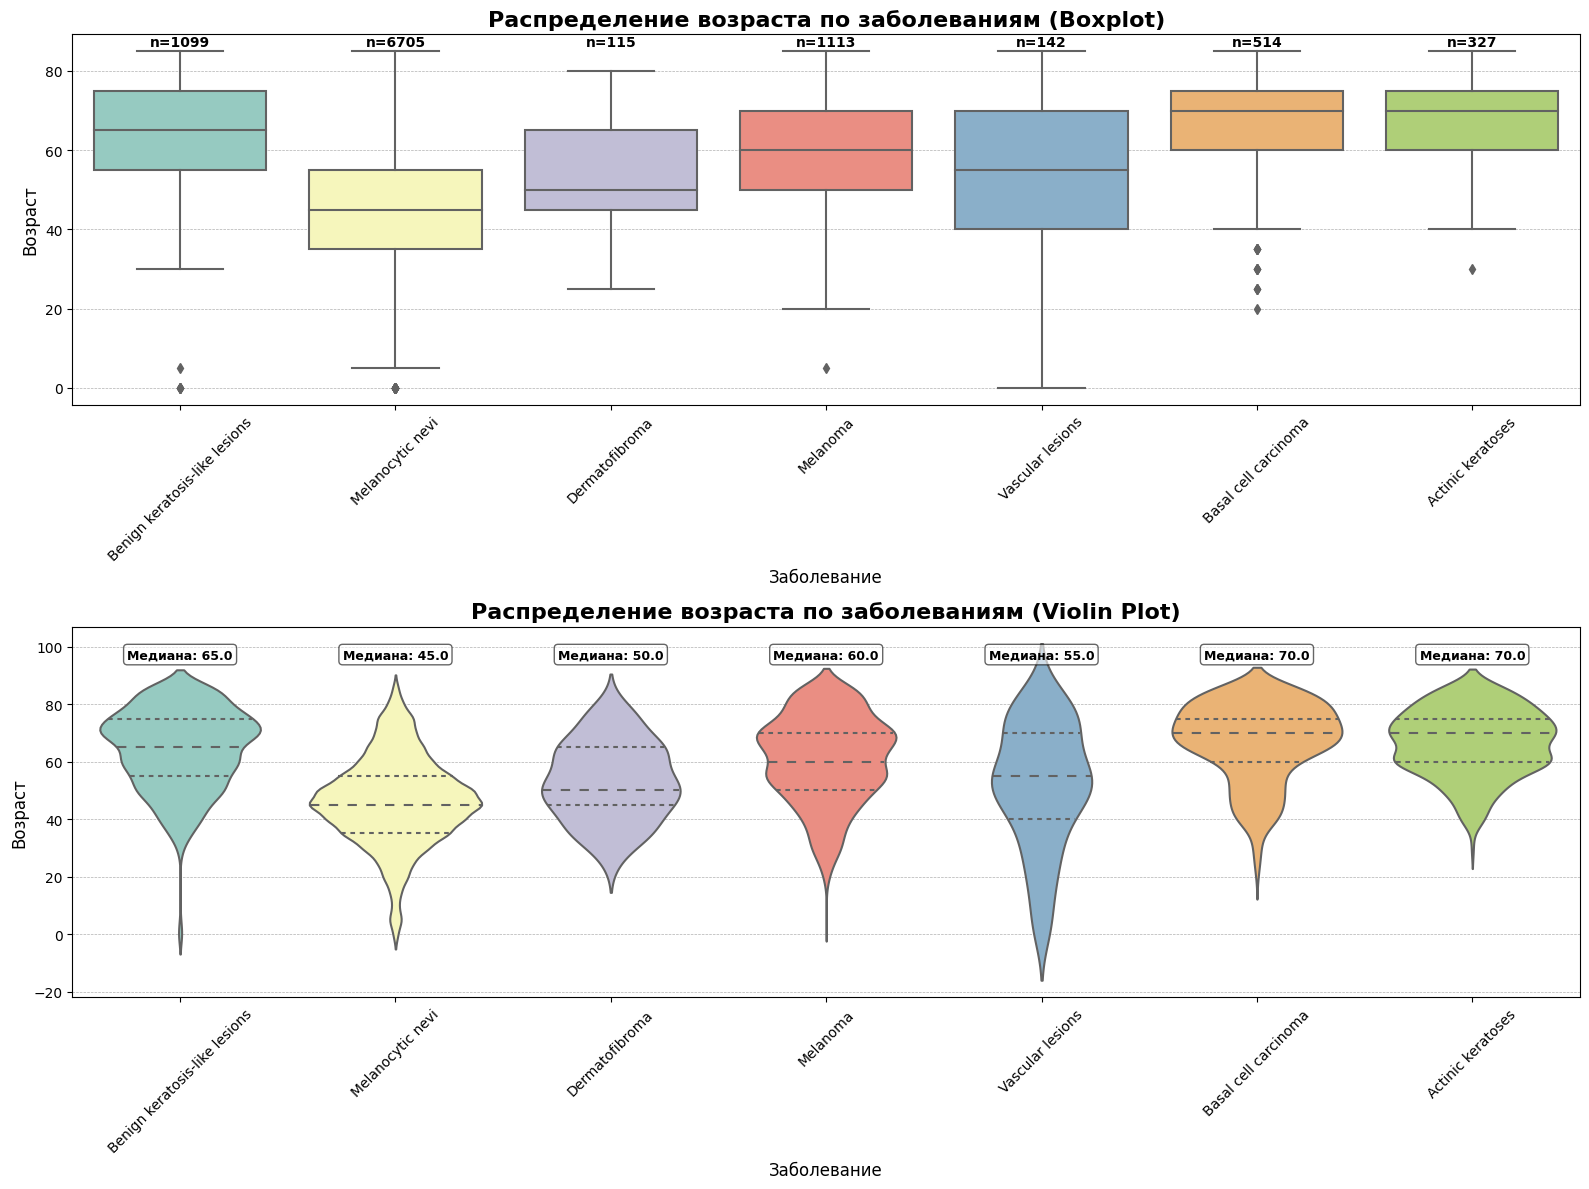

In [15]:
plt.figure(figsize=(16, 10))

# Убираем пропуски в возрасте
age_data = metadata.dropna(subset=['age'])

# Создаем subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Boxplot
sns.boxplot(data=age_data, x='label', y='age', ax=ax1, palette='Set3')
ax1.set_title('Распределение возраста по заболеваниям (Boxplot)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Заболевание', fontsize=12)
ax1.set_ylabel('Возраст', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Добавляем горизонтальную сетку
ax1.grid(axis='y', alpha=1, linestyle='--', linewidth=0.5)
ax1.set_axisbelow(True)  # Сетка behind the plot elements

# Добавляем аннотации с количеством наблюдений
for i, disease in enumerate(age_data['label'].unique()):
    n = len(age_data[age_data['label'] == disease])
    ax1.text(i, age_data['age'].max() + 0.5, f'n={n}', ha='center', va='bottom', fontweight='bold')

# Violin plot
sns.violinplot(data=age_data, x='label', y='age', ax=ax2, palette='Set3', inner='quartile')
ax2.set_title('Распределение возраста по заболеваниям (Violin Plot)', fontsize=16, fontweight='bold')
ax2.set_xlabel('Заболевание', fontsize=12)
ax2.set_ylabel('Возраст', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

medians = age_data.groupby('label')['age'].median()

y_max = age_data['age'].max()
for i, disease in enumerate(age_data['label'].unique()):
    median_age = medians[disease]
    # Размещаем текст значительно выше максимального значения
    ax2.text(i, y_max + 10, f'Медиана: {median_age:.1f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=9,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6))
# Добавляем горизонтальную сетку
ax2.grid(axis='y', alpha=1, linestyle='--', linewidth=0.5)
ax2.set_axisbelow(True)  # Сетка behind the plot elements

plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

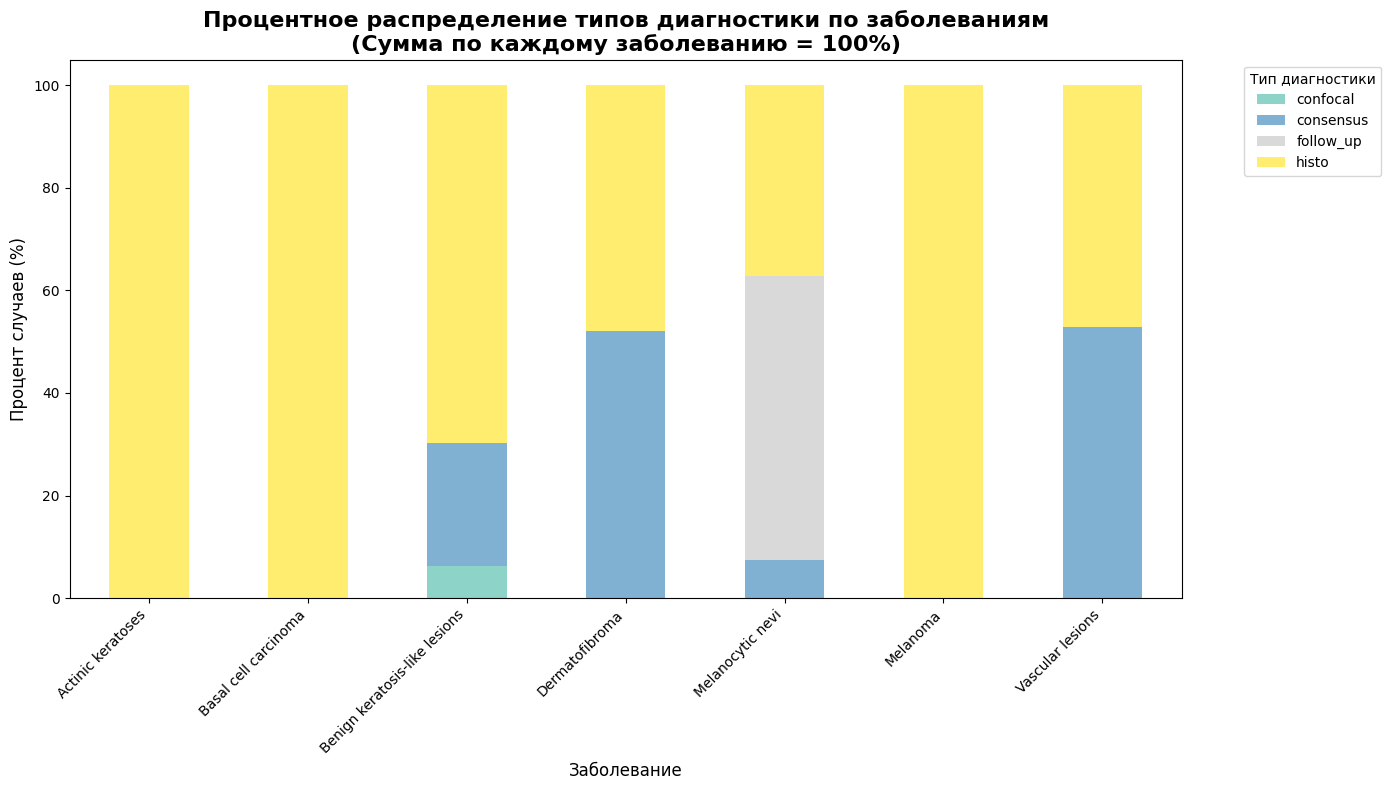

In [16]:
plt.figure(figsize=(14, 8))

cross_tab = pd.crosstab(metadata_balanced['label'], metadata_balanced['dx_type'])
cross_tab_perc = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

ax = cross_tab_perc.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Set3')

plt.title('Процентное распределение типов диагностики по заболеваниям\n(Сумма по каждому заболеванию = 100%)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Заболевание', fontsize=12)
plt.ylabel('Процент случаев (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Тип диагностики', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
dummy_columns = ['dx_type', 'localization']

metadata_balanced['sex'] = metadata_balanced['sex'].map({'male': 0, 'female': 1, 'unknown':2})

dummy_df = pd.get_dummies(metadata_balanced[dummy_columns])

metadata_balanced = pd.concat([metadata_balanced, dummy_df], axis=1)
metadata_balanced.drop(dummy_columns, inplace = True, axis = 1)

metadata_balanced['age'] = (metadata_balanced['age'] - np.min(metadata_balanced['age']))/(np.max(metadata_balanced['age'])-np.min(metadata_balanced['age']))
metadata_balanced.info()


<class 'pandas.core.frame.DataFrame'>
Index: 46870 entries, 9687 to 2461
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   lesion_id                     46870 non-null  object 
 1   image_id                      46870 non-null  object 
 2   dx                            46870 non-null  int64  
 3   age                           46870 non-null  float64
 4   sex                           46870 non-null  int64  
 5   label                         46870 non-null  object 
 6   path                          46870 non-null  object 
 7   dx_type_confocal              46870 non-null  bool   
 8   dx_type_consensus             46870 non-null  bool   
 9   dx_type_follow_up             46870 non-null  bool   
 10  dx_type_histo                 46870 non-null  bool   
 11  localization_abdomen          46870 non-null  bool   
 12  localization_acral            46870 non-null  bool   
 13  loca

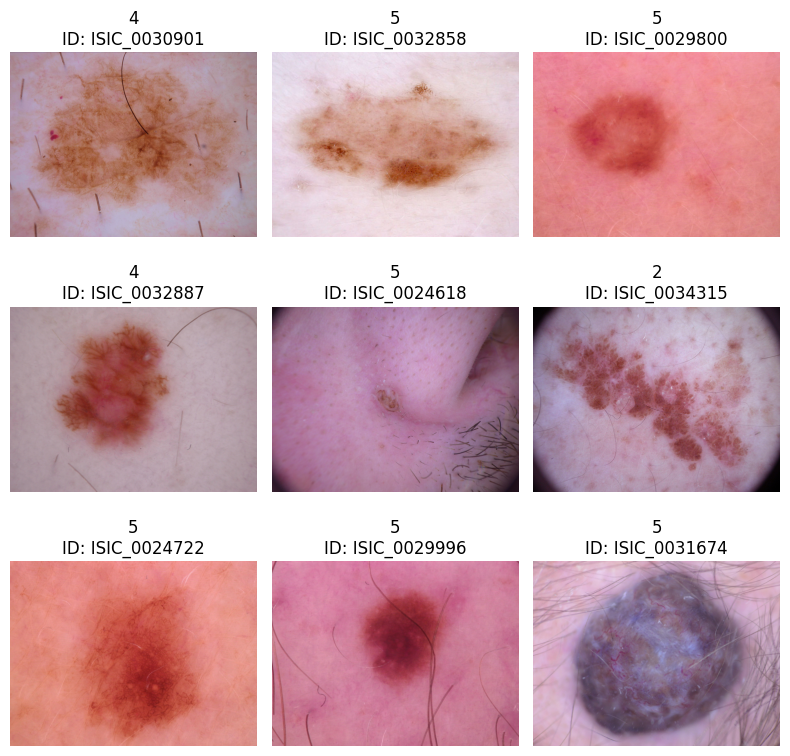

In [18]:
random_ids = random.sample(list(image_path.keys()), 9)

plt.figure(figsize=(8, 8))
for i, img_id in enumerate(random_ids):
   img_path = image_path[img_id]
   img = Image.open(img_path) 
   
   # Find the label for this image ID
   row = metadata[metadata['image_id'] == img_id]
   if not row.empty:
       label = row['dx'].iloc[0]
   else:
       label = 'Unknown'
   
   plt.subplot(3, 3, i+1)
   plt.imshow(img)
   plt.title(f'{label}\nID: {img_id}')
   plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
input_size = 224
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(), 
    transforms.Normalize(norm_mean, norm_std)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)), 
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

train_df, test_df = train_test_split(metadata_balanced, test_size=0.2, random_state=42, stratify=metadata_balanced['label'])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['label'])

In [20]:
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_paths = dataframe['path'].values
        self.dx = dataframe['dx'].values
        self.transform = transform
        
        # Заранее извлекаем все метаданные
        self.metadata_columns = [2, 4] + list(range(7, 26))
        self.all_metadata = self.df.iloc[:, self.metadata_columns].values.astype(np.float32)
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.dx[idx]
        
        # Быстрый доступ к предзагруженным метаданным
        metadata = self.all_metadata[idx]
        
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(metadata, dtype=torch.float32), label
        
# Create datasets with transforms
train_dataset = SkinDataset(train_df, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)
test_dataset = SkinDataset(test_df, transform=val_transform)

torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes

train_loader = DataLoader(
   train_dataset, 
   batch_size=32,             # For RTX 40/50: use 128+ (more VRAM available)
   shuffle=True, 
   num_workers=0,              # For RTX 40/50: use 8+ workers (more CPU cores)
   pin_memory=True,                         # For RTX 40/50: use 4+ prefetch
)

val_loader = DataLoader(
   val_dataset, 
   batch_size=64,             
   shuffle=False, 
   num_workers=0,              # For RTX 40/50: use 6+ workers
   pin_memory=True,            
)

test_loader = DataLoader(
   test_dataset, 
   batch_size=64,             
   shuffle=False, 
   num_workers=0,              # For RTX 40/50: use 4+ workers
   pin_memory=True,
)

In [21]:
images, _, labels = next(iter(train_loader))

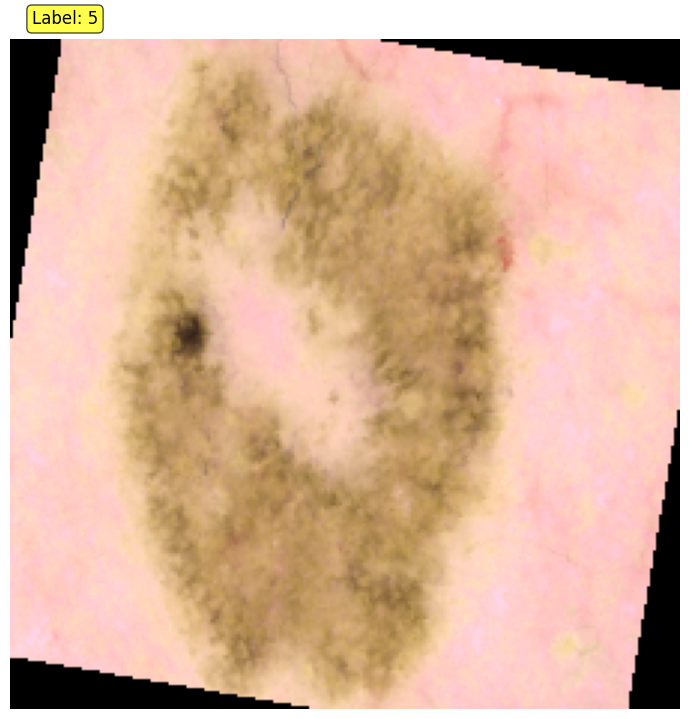

In [22]:
# Ограничиваем количество изображений для отображения
image = images[0]
label = labels[0]

# Денормализация изображений
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
denormalized_image = image * std + mean
denormalized_image = torch.clamp(denormalized_image, 0, 1)

# Создаем grid
grid = torchvision.utils.make_grid(denormalized_image, nrow=4, padding=2)

# Визуализируем
plt.figure(figsize=(7, 7))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')

plt.figtext(0.1, 1, f'Label: {label}', ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

In [23]:
from torchinfo import summary
efficient_net = models.efficientnet_b0(weights=None)
efficient_net = torch.load('/kaggle/input/efficientnetb0/pytorch/default/1/EfficientNet_B0_Weights.pth', weights_only = False)
summary(efficient_net, (32,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

In [24]:
class SkinLesionModel(nn.Module):
    def __init__(self, num_classes=7, freeze_backbone=True):
        super(SkinLesionModel, self).__init__()
        
        # Визуальный backbone (EfficientNet)
        self.visual_backbone = efficient_net
        
        if freeze_backbone:
            for param in self.visual_backbone.parameters():
                param.requires_grad = False
        
        # Заменяем классификатор изображений
        in_features_visual = self.visual_backbone.classifier[1].in_features
        self.visual_backbone.classifier = nn.Identity()  # Убираем старый классификатор
        
        # Метаданные branch
        self.metadata_branch = nn.Sequential(
            nn.Linear(21, 128),  # Увеличиваем capacity
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Объединенный классификатор
        self.classifier = nn.Sequential(
            nn.Linear(in_features_visual + 32, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Инициализация весов"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, image, metadata):
        visual_features = self.visual_backbone(image)
        metadata_features = self.metadata_branch(metadata)
        combined_features = torch.cat([visual_features, metadata_features], dim=1)
        return self.classifier(combined_features)
    
    def unfreeze_backbone(self, unfreeze_all=False, num_layers_to_unfreeze=10):
        """Разморозка слоев visual backbone"""
        if unfreeze_all:
            # Разморозить все слои
            for param in self.visual_backbone.parameters():
                param.requires_grad = True
            print("Unfroze all backbone layers")
        else:
            # Разморозить только последние N слоев
            # Сначала заморозить все
            for param in self.visual_backbone.parameters():
                param.requires_grad = False
            
            # Разморозить последние N слоев
            total_layers = len(list(self.visual_backbone.parameters()))
            parameters_to_unfreeze = list(self.visual_backbone.parameters())[-num_layers_to_unfreeze:]
            
            for param in parameters_to_unfreeze:
                param.requires_grad = True
            
            print(f"Unfroze last {num_layers_to_unfreeze} layers out of {total_layers}")

In [25]:
def train_epoch_multimodal(model, loader, criterion, optimizer, device):
    """Одна эпоха обучения для мультимодальной модели"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, metadata, targets) in enumerate(loader):
        images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch_multimodal(model, loader, criterion, device):
    """Одна эпоха валидации для мультимодальной модели"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, metadata, targets in loader:
            images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def evaluate_multimodal_model(model, loader, criterion, device):
    """Полная оценка модели на тестовом наборе"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, metadata, targets in loader:
            images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss = running_loss / len(loader)
    test_acc = balanced_accuracy_score(all_targets, all_preds) * 100
    
    # Classification report
    test_report = classification_report(all_targets, all_preds)
    
    return test_loss, test_acc, test_report

In [26]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_multimodal_model(model, train_loader, val_loader, test_loader, device, 
                          num_epochs=50, learning_rate=1e-3, fine_tune_epochs=10):
    """
    Полный цикл обучения мультимодальной модели
    """
    # Loss function with class weights
    class_counts = torch.bincount(torch.tensor([label for _, _, label in train_loader.dataset]))
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Optimizer
    optimizer = optim.AdamW([
        {'params': model.visual_backbone.parameters(), 'lr': learning_rate/10},
        {'params': model.metadata_branch.parameters(), 'lr': learning_rate},
        {'params': model.classifier.parameters(), 'lr': learning_rate}
    ], weight_decay=1e-4)
    
    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    # Early stopping
    early_stopping = EarlyStopping(patience=7)
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }
    
    print("Starting Phase 1: Training classifier layers...")
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch_multimodal(
            model, train_loader, criterion, optimizer, device
        )
        
        # Validate
        val_loss, val_acc = validate_epoch_multimodal(
            model, val_loader, criterion, device
        )
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
        print('-' * 50)
        
        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break
    
    # Phase 2: Fine-tuning
    print("Starting Phase 2: Fine-tuning backbone...")
    model.unfreeze_backbone(unfreeze_all=False)
    
    # New optimizer with lower learning rate for fine-tuning
    optimizer_ft = optim.AdamW([
        {'params': model.visual_backbone.parameters(), 'lr': learning_rate/100},
        {'params': model.metadata_branch.parameters(), 'lr': learning_rate/10},
        {'params': model.classifier.parameters(), 'lr': learning_rate/10}
    ], weight_decay=1e-5)
    
    scheduler_ft = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=fine_tune_epochs)
    
    for epoch in range(fine_tune_epochs):
        train_loss, train_acc = train_epoch_multimodal(
            model, train_loader, criterion, optimizer_ft, device
        )
        
        val_loss, val_acc = validate_epoch_multimodal(
            model, val_loader, criterion, device
        )
        
        scheduler_ft.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer_ft.param_groups[0]['lr'])
        
        print(f'Fine-tuning Epoch {epoch+1}/{fine_tune_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 50)
    
    # Final evaluation
    test_loss, test_acc, test_report = evaluate_multimodal_model(
        model, test_loader, criterion, device
    )
    
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print("\nClassification Report:")
    print(test_report)
    
    return model, history

def evaluate_multimodal_model(model, loader, criterion, device):
    """Полная оценка модели"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, metadata, targets in loader:
            images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss = running_loss / len(loader)
    test_acc = balanced_accuracy_score(all_targets, all_preds) * 100
    test_report = classification_report(all_targets, all_preds)
    
    return test_loss, test_acc, test_report

In [27]:
def analyze_feature_importance(model, test_loader, device):
    """Анализ вклада разных модальностей"""
    model.eval()
    
    # Только визуальные признаки
    visual_only_preds = []
    # Только метаданные
    metadata_only_preds = []
    # Все признаки
    combined_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, metadata, targets in test_loader:
            images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)
            
            # Только визуальные
            visual_features = model.visual_backbone(images)
            zeros_meta = torch.zeros_like(model.metadata_branch(metadata))
            visual_output = model.classifier(torch.cat([visual_features, zeros_meta], dim=1))
            visual_only_preds.extend(torch.argmax(visual_output, 1).cpu().numpy())
            
            # Только метаданные
            metadata_features = model.metadata_branch(metadata)
            zeros_visual = torch.zeros_like(visual_features)
            metadata_output = model.classifier(torch.cat([zeros_visual, metadata_features], dim=1))
            metadata_only_preds.extend(torch.argmax(metadata_output, 1).cpu().numpy())
            
            # Все признаки
            combined_output = model(images, metadata)
            combined_preds.extend(torch.argmax(combined_output, 1).cpu().numpy())
            
            all_targets.extend(targets.cpu().numpy())
    
    print("Feature Importance Analysis:")
    print("=" * 40)
    print(f"Visual only accuracy: {balanced_accuracy_score(all_targets, visual_only_preds)*100:.2f}%")
    print(f"Metadata only accuracy: {balanced_accuracy_score(all_targets, metadata_only_preds)*100:.2f}%")
    print(f"Combined accuracy: {balanced_accuracy_score(all_targets, combined_preds)*100:.2f}%")

In [ ]:
# Создание модели
model = SkinLesionModel(num_classes=7, freeze_backbone=True)
model = model.to(device)

# Обучение
trained_model, history = train_multimodal_model(
    model, train_loader, val_loader, test_loader, device,
    num_epochs=8, learning_rate=1e-3, fine_tune_epochs=8
)
 
# Анализ важности признаков
analyze_feature_importance(trained_model, test_loader, device)

Starting Phase 1: Training classifier layers...
Epoch 1/8:
Train Loss: 1.6213 | Train Acc: 70.82%
Val Loss: 0.0669 | Val Acc: 97.77%
LR: 1.00e-04
--------------------------------------------------
Epoch 2/8:
Train Loss: 0.5981 | Train Acc: 83.19%
Val Loss: 0.0602 | Val Acc: 98.51%
LR: 1.00e-04
--------------------------------------------------
Epoch 3/8:
Train Loss: 0.3937 | Train Acc: 87.45%
Val Loss: 0.0621 | Val Acc: 98.68%
LR: 1.00e-04
--------------------------------------------------
Epoch 4/8:
Train Loss: 0.2974 | Train Acc: 90.09%
Val Loss: 0.0400 | Val Acc: 99.05%
LR: 1.00e-04
--------------------------------------------------
Epoch 5/8:
Train Loss: 0.2193 | Train Acc: 92.49%
Val Loss: 0.0248 | Val Acc: 99.57%
LR: 1.00e-04
--------------------------------------------------
Epoch 6/8:
Train Loss: 0.2045 | Train Acc: 93.01%
Val Loss: 0.0326 | Val Acc: 99.58%
LR: 1.00e-04
--------------------------------------------------
Epoch 7/8:
Train Loss: 0.1700 | Train Acc: 94.44%
Val Loss